In [1]:
using BenchmarkTools
using Plots
using Distributions
using LinearAlgebra

include("parallelized_DLA.jl")

Main.DLA_parallel

## Initialize constants

In [2]:
desired_cluster_mass = 2500
spawn_density = 0.8
num_steps = 10_000
max_radius = 150
spawn_cap = 300
deposit_prob = 1
;

In [3]:
@time cluster = DLA_parallel.run_parallel_DLA(desired_cluster_mass, spawn_density, num_steps, max_radius, spawn_cap, deposit_prob)

 Mass = 2499, r_B = 64, r_D = 128 396.780648 seconds (4.13 G allocations: 201.076 GiB, 11.10% gc time, 0.51% compilation time)


2500-element Vector{Any}:
 [0, 0]
 [0, -1]
 [-1, 0]
 [1, 0]
 [-1, -1]
 [1, 1]
 [-1, -2]
 [2, 1]
 [-1, -3]
 [1, 2]
 [3, 1]
 [3, 2]
 [1, -1]
 ⋮
 [53, -24]
 [32, 48]
 [60, -19]
 [-46, -30]
 [57, 26]
 [-57, 23]
 [-6, 61]
 [58, -17]
 [-2, -58]
 [-7, 61]
 [-14, -60]
 [-15, -60]

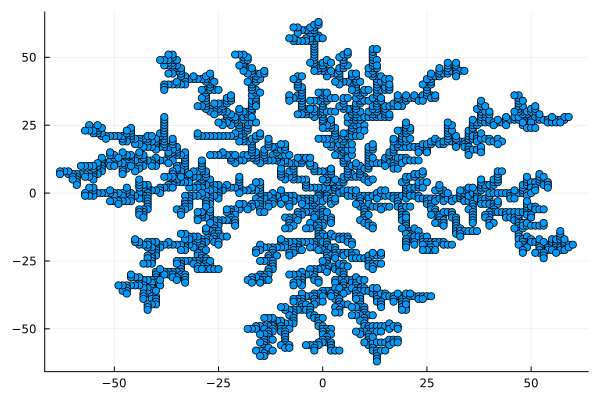

In [4]:
fig = scatter()
scatter!(fig, ([v[1] for v in cluster], [v[2] for v in cluster]), label="")

# Appendix 1: Obtaining the grid points on a circle

In [2]:
r = 12
θ = range(-π, π, 300)

grid_circle = Utils.get_circle_points(r)
round_circle = [r * cos.(θ), r* sin.(θ)]
;

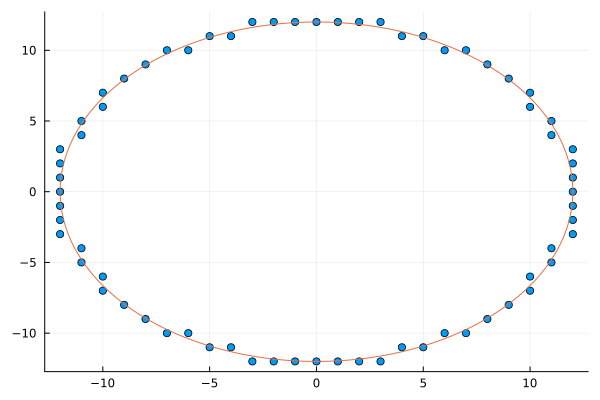

In [3]:
fig = scatter([v[1] for v in grid_circle], [v[2] for v in grid_circle], label="")
plot!(fig, (round_circle[1], round_circle[2]), label="")

#### Get number of grid points for each radius

In [4]:
radii = collect(1:80)
num_gridpoints_on_circle = map(
    x -> length(Utils.get_circle_points(x)),
    radii
)
;

Perform linear regression

In [5]:
using DataFrames, GLM, StatsBase

In [6]:
data = DataFrame(X=radii, Y=num_gridpoints_on_circle)
ols = lm(@formula(Y ~ X), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  -0.110127  0.263293      -0.42    0.6769  -0.634303   0.414049
X             5.65827   0.00564754  1001.90    <1e-99   5.64703    5.66952
───────────────────────────────────────────────────────────────────────────

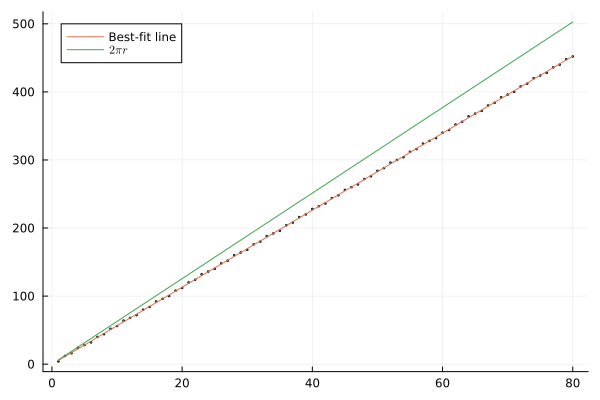

In [7]:
fig = scatter(radii, num_gridpoints_on_circle, markersize=1, label="")
plot!(fig, (radii, predict(ols)), label="Best-fit line")

plot!(fig, (radii, (2*pi) .* radii), label=raw"$2\pi r$")

# Appendix 2: Benchmarking

#### Benchmarking Initialization Function

In [8]:
r = 100_000
@benchmark Utils.get_circle_points($r)

BenchmarkTools.Trial: 10000 samples with 997 evaluations.
 Range (min … max):  21.966 ns …  5.673 μs  ┊ GC (min … max): 0.00% … 99.04%
 Time  (median):     25.677 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   27.882 ns ± 78.704 ns  ┊ GC (mean ± σ):  4.41% ±  1.70%

        ▄█▁▇▄▃▁▂                                               
  ▂▃▃▄▅█████████▄▅▃▃▃▃▃▅▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂ ▃
  22 ns           Histogram: frequency by time        43.6 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

#### Benchmarking Random Walk Generation

In [14]:
num_walkers = 3
num_steps = 100
birth_radius = rand(5:10)

@benchmark DLA_parallel.generate_trajectories($num_walkers, num_steps, $birth_radius)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  15.400 μs …  16.519 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     22.200 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   47.086 μs ± 306.882 μs  ┊ GC (mean ± σ):  9.55% ± 2.42%

  █▅▅▆▆▃▃▃▃▂▁▁                                                 ▂
  █████████████▇██▆▇▆▅▆▆▅▅▆▆▅▆▅▅▅▆▅▅▅▆▅▅▅▆▅▆▅▅▄▄▅▅▅▅▄▅▄▅▅▄▅▁▅▃ █
  15.4 μs       Histogram: log(frequency) by time       262 μs <

 Memory estimate: 28.92 KiB, allocs estimate: 309.

In [2]:
num_walkers = 5
num_steps = 10
birth_radius = 5

@code_llvm DLA_parallel.generate_trajectories(num_walkers, num_steps, birth_radius)

;  @ c:\Users\User\Desktop\PHYSICS RESOURCES\PHYSICS 215 (HPC Julia)\Final Project\phy215-final\Julia_parallelized_DLA\parallelized_DLA.jl:75 within `generate_trajectories`
; Function Attrs: uwtable
define nonnull {}* @julia_generate_trajectories_1379(i64 signext %0, i64 signext %1, i64 signext %2) #0 {
top:
  %3 = alloca [3 x {}*], align 8
  %gcframe122 = alloca [6 x {}*], align 16
  %gcframe122.sub = getelementptr inbounds [6 x {}*], [6 x {}*]* %gcframe122, i64 0, i64 0
  %.sub = getelementptr inbounds [3 x {}*], [3 x {}*]* %3, i64 0, i64 0
  %4 = bitcast [6 x {}*]* %gcframe122 to i8*
  call void @llvm.memset.p0i8.i64(i8* align 16 %4, i8 0, i64 48, i1 true)
  %newstruct49 = alloca [1 x [1 x i64]], align 8
  %newstruct50 = alloca { i64, [1 x [1 x i64]] }, align 8
  %5 = call {}*** inttoptr (i64 140733389852256 to {}*** ()*)() #5
;  @ c:\Users\User\Desktop\PHYSICS RESOURCES\PHYSICS 215 (HPC Julia)\Final Project\phy215-final\Julia_parallelized_DLA\parallelized_DLA.jl:76 within `generate

#### Benchmarking `is_adjacent_to_cluster` function

In [28]:
directions = [[1, 0], [-1, 0], [0, 1], [0, -1]]
cluster_particles = 500

cluster_aggregate = rand(directions, cluster_particles)
walker_position = rand(1:5) .* rand(directions) + rand(1:5) .* rand(directions)

@benchmark DLA_parallel.is_adjacent_to_cluster($walker_position, cluster_aggregate)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  30.700 μs …   6.549 ms  ┊ GC (min … max): 0.00% … 98.50%
 Time  (median):     34.200 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   49.619 μs ± 164.508 μs  ┊ GC (mean ± σ):  8.82% ±  2.93%

  █▆▄▄▄▃▃▄▃▃▂▂▂▁▂▂▁                                            ▁
  ███████████████████▇██▇█▇▆▇▆▅▆▆▆▆▅▅▆▅▅▅▇█▅▄▅▆▆▅▄▄▄▅▄▄▃▄▃▄▄▃▂ █
  30.7 μs       Histogram: log(frequency) by time       161 μs <

 Memory estimate: 43.22 KiB, allocs estimate: 506.

In [30]:
directions = [[1, 0], [-1, 0], [0, 1], [0, -1]]
cluster_particles = 500

cluster_aggregate = rand(directions, cluster_particles)
walker_position = rand(1:5) .* rand(directions) + rand(1:5) .* rand(directions)

@code_llvm DLA_parallel.is_adjacent_to_cluster(walker_position, cluster_aggregate)

;  @ c:\Users\User\Desktop\PHYSICS RESOURCES\PHYSICS 215 (HPC Julia)\Final Project\phy215-final\Julia_parallelized_DLA\parallelized_DLA.jl:90 within `is_adjacent_to_cluster`
; Function Attrs: uwtable
define i8 @julia_is_adjacent_to_cluster_3265({}* noundef nonnull align 16 dereferenceable(40) %0, {}* noundef nonnull align 16 dereferenceable(40) %1) #0 {
top:
  %2 = alloca [2 x {}*], align 8
  %gcframe7 = alloca [5 x {}*], align 16
  %gcframe7.sub = getelementptr inbounds [5 x {}*], [5 x {}*]* %gcframe7, i64 0, i64 0
  %.sub = getelementptr inbounds [2 x {}*], [2 x {}*]* %2, i64 0, i64 0
  %3 = bitcast [5 x {}*]* %gcframe7 to i8*
  call void @llvm.memset.p0i8.i64(i8* align 16 %3, i8 0, i64 40, i1 true)
  %4 = getelementptr inbounds [5 x {}*], [5 x {}*]* %gcframe7, i64 0, i64 3
  %5 = getelementptr inbounds [5 x {}*], [5 x {}*]* %gcframe7, i64 0, i64 2
  %6 = alloca { [1 x { [2 x {}*] }], [1 x [1 x i64]] }, align 8
  %7 = call {}*** inttoptr (i64 140733389852256 to {}*** ()*)() #4
;  @ c

#### Benchmarking the `norm`

In [57]:
cluster_aggregate = [[1, 2], [3, 4], [5, 6]]
walker_position = [1, 0]

println(norm.(cluster_aggregate .- Ref(walker_position)).^2)
@code_llvm norm.(cluster_aggregate .- Ref(walker_position))

[4.0, 20.000000000000004, 51.99999999999999]
;  @ none within `##dotfunction#285#17`
; Function Attrs: uwtable
define nonnull {}* @"julia_##dotfunction#285#17_4456"({}* noundef nonnull align 16 dereferenceable(40) %0, {}* noundef nonnull align 8 dereferenceable(8) %1) #0 {
top:
  %gcframe4 = alloca [4 x {}*], align 16
  %gcframe4.sub = getelementptr inbounds [4 x {}*], [4 x {}*]* %gcframe4, i64 0, i64 0
  %2 = bitcast [4 x {}*]* %gcframe4 to i8*
  call void @llvm.memset.p0i8.i64(i8* align 16 %2, i8 0, i64 32, i1 true)
  %3 = getelementptr inbounds [4 x {}*], [4 x {}*]* %gcframe4, i64 0, i64 3
  %4 = getelementptr inbounds [4 x {}*], [4 x {}*]* %gcframe4, i64 0, i64 2
  %5 = alloca { [1 x { [2 x {}*] }], [1 x [1 x i64]] }, align 8
  %6 = call {}*** inttoptr (i64 140733389852256 to {}*** ()*)() #6
; ┌ @ broadcast.jl:903 within `materialize`
; │┌ @ broadcast.jl:306 within `instantiate`
; ││┌ @ broadcast.jl:525 within `combine_axes`
; │││┌ @ broadcast.jl:234 within `axes`
; ││││┌ @ broadca

##### Norm calculation using multi-dimensional arrays

In [63]:
cluster_aggregate = [ 1 3 5; 2 4 6]
walker_position = [1, 0]

function naive_rel_position(cluster_aggregate, walker_position, cluster_particle_number)
    relative_position = (cluster_aggregate .- walker_postion).^2
    squared_norm = zeros(column_number)
    for i in 1 : column_number
        squared_norm[i] = sum(@view(vector_array[:, i]) )
    end
    return squared_norm
end

print(naive_norm(relative_position, 3)) 
@code_llvm f(relative_position) 

[4.0, 20.0, 52.0];  @ In[56]:5 within `f`
; Function Attrs: uwtable
define nonnull {}* @julia_f_4568({}* noundef nonnull align 16 dereferenceable(40) %0) #0 {
top:
  %gcframe2 = alloca [3 x {}*], align 16
  %gcframe2.sub = getelementptr inbounds [3 x {}*], [3 x {}*]* %gcframe2, i64 0, i64 0
  %1 = bitcast [3 x {}*]* %gcframe2 to i8*
  call void @llvm.memset.p0i8.i64(i8* align 16 %1, i8 0, i64 24, i1 true)
  %2 = getelementptr inbounds [3 x {}*], [3 x {}*]* %gcframe2, i64 0, i64 2
  %3 = alloca { [1 x {}*], [2 x i64] }, align 8
  %4 = call {}*** inttoptr (i64 140733389852256 to {}*** ()*)() #6
  %5 = bitcast [3 x {}*]* %gcframe2 to i64*
  store i64 4, i64* %5, align 16
  %6 = getelementptr inbounds [3 x {}*], [3 x {}*]* %gcframe2, i64 0, i64 1
  %7 = bitcast {}** %6 to {}***
  %8 = load {}**, {}*** %4, align 8
  store {}** %8, {}*** %7, align 8
  %9 = bitcast {}*** %4 to {}***
  store {}** %gcframe2.sub, {}*** %9, align 8
  %.fca.0.0.gep = getelementptr inbounds { [1 x {}*], [2 x i64] }